# CRISMIS GSOC Project

This test consists of 3 tasks: 

1. Retrieving data from an specific date and plotting 2 images
2. Discerning between images that have Cosmic Rays and those that don't have and constructing a dataset.
3. Training a machine learning algorithm with the dataset constructed in task 2

To achieve the expected results, we must define a series of functions that will help us.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, datasets, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import bs4
import requests
import os
import glob
import re
from deepCR import deepCR

**get_image** will receive the path to the .IMG file, parse the header with regular expressions and reconstructs the original image as an image numpay array. It returns the name as a string and the image as a numpay array.

In [2]:
def get_image(filename):
    """ gets the image from the .IMG file
    Args:
        filename (string): path to file
    """
    aux = 0 #index of end of header
    with open(filename, mode='rb') as file:
        fileContent = file.readlines()
        for i in range(len(fileContent)-1):
            line = str(fileContent[i]).split()
            if len(line) < 2: #blank line
                continue
            elif len(re.findall(r'PRODUCT_ID',line[0])) > 0:
                name = re.findall(r'(?<=\")(.*?)(?=\")', str(line[-1]))[0]
            elif len(re.findall(r'LINES',line[1])) > 0:
                width = int(re.findall(r'\d+', str(line[-1]))[0])
            elif len(re.findall(r'LINE_SAMPLES',line[1])) > 0:
                height = int(re.findall(r'\d+', str(line[-1]))[0])
            elif len(re.findall(r'SAMPLE_BITS',line[1])) > 0:
                bits = int(re.findall(r'\d+', str(line[-1]))[0])
            elif len(re.findall(r'END_OBJECT',line[0])) > 0:
                aux = i
                
        list_image_bytes = fileContent[aux+2:]
        image_bytes = b"".join(x for x in list_image_bytes)
        trailing_bytes = (len(image_bytes) % bits) #It seems some images are missing some bytes?
        if trailing_bytes > 0:
            image_bytes = image_bytes[0:-trailing_bytes]
        
    dtype = np.dtype(np.int_) 
    if bits == 8:
        dtype = np.dtype(np.uint8)
    elif bits == 16:
        dtype = np.dtype(np.uint16)
    elif bits == 32:
        dtype = np.dtype(np.uint32)
    elif bits == 64:
        dtype = np.dtype(np.uint64)
        
    shape = (width,height)
    image = np.frombuffer(image_bytes,dtype)[0:width*height].reshape(shape)
    return name, image

**discern** uses a module called [deepCR](https://github.com/profjsb/deepCR). According to the [paper](https://arxiv.org/pdf/1907.09500.pdf), deepCR consists of two neural networks: *deepCR-mask* and *deepCR-inpaint*, which are based on [UNet](https://arxiv.org/pdf/1505.04597.pdf), an encoder-decoder CNN with skip connections. 

*deepCR-mask* takes as an input an image and returns a binary mask of each pixel with value 1 in the *i* position if the pixel *i* is affected by Cosmic Rays, and value 0 if the pixel isn't.

*deepCR-inpaint* takes the image and the binary mask generated by *deepCR-mask* and reconstruct the image with an approximation of what it would be without Cosmic Rays.

For our purposes, only *deepCR-mask* is of interest to us, as we use it to identify if the given image has Cosmic Rays. For that, we seek the presence of at least one "1" inside the binary mask and save the image inside the appropriate folder ("CR" for cosmic rays, "clean" for not having cosmic rays). We can use the *threshold* parameter to focus on sensitivity or specificity

In [3]:
def discern(filepath,device):
    """Determines if a given .IMG have CRs or not, saving the image as .png in the appropriate folder
    Args:
        filepath (string): path to filename
        device (string): device to be used to identify CRs
    """
    #print(filepath)
    mdl = deepCR(mask="ACS-WFC-F606W-2-32",inpaint="ACS-WFC-F606W-2-32",device=device)
    name, image = get_image(filepath)
    mask = mdl.clean(image, threshold = 0.5, inpaint=False)
    if 1 in mask:
        plt.imshow(image, cmap = "gray")
        plt.savefig("./DATA/" + date + "dataset/CR/" + name)
        print(name + " has Cosmic Rays!")
    else:
        plt.imshow(image, cmap = "gray")
        plt.savefig("./DATA/" + date + "dataset/clean/" + name)
        print(name + " doesn't have Cosmic Rays")

In [4]:
def split(dataset,rate=0.8):
    """Ramdomly splits the dataset in training and testing sets
    
    Args:
        dataset (Dataset): dataset to be split
        rate (float,optional): rate of the whole dataset that will be used as the training set. Default = 0.8
    """
    
    train_size = int(rate*len(dataset))
    test_size = len(dataset) - train_size
    
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,test_size])
    return train_dataset, test_dataset

In [5]:
def train(model,loader,optimizer,criterion,epochs,device):
    """Trains the given model
    
    Args:
        model (nn.Module inherited class) : model used
        loader (data.DataLoader) : loader used for training 
        optimizer (optim): optimizer
        criterion: criterion used for the optimization
        epochs (int): # epochs for training 
    """
    epoch_values = [] 
    for j in range(epochs):

        running_loss = 0.0
        loss_values = 0
        num_batches = 0
        
        for i, data in enumerate(loader, 0):
    
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            loss_values += loss.item()
            num_batches += 1
            if i % 10 == 9:
                print('[%d, %5d] loss: %.3f' %
                          (j + 1, i + 1, running_loss / 10))
                running_loss = 0.0
                
        epoch_values.append(loss_values / num_batches)
                
    plt.plot(np.array(epoch_values), 'r')
    plt.savefig('training_error.png')

    print("Finished training")
    
    return model

In [6]:
def testing(model,loader,device):
    
    """Tests the given model
    
    Args:
        model (nn.Module inherited class) : model used
        loader (data.DataLoader) : loader used for training 
    """

    correct = 0
    error = 0
    total = 0
    
    with torch.no_grad():
        for data in loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            aux, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))

Here we set the date from which we will be retrieving the images. In a final product this could be changed to take a list of dates.

In [7]:
year = 2011
day = 207
date = str(year) + "_" + str(day) + "/"

The block below is a rudimentary web scraper, it takes the date and retrieve every .IMG of the corresponding website. It only needs to be executed once. In a final product, the scraper can be more sophisticated using [scrapy](https://scrapy.org/), so that a series of custom rules can be added, such as selection of some specific .IMGs. Also, a flag can be added to determine if the current run will use the web scraper or not.

In [ ]:
os.mkdir("./DATA/")
os.mkdir("./DATA/" + date)
os.mkdir("./DATA/" + date + "dataset/")
url = "https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/" + date
r = requests.get(url)
data = bs4.BeautifulSoup(r.text, "html.parser")
for l in data.find_all("a"):
    r = requests.get(url + l["href"])
    #print(r.status_code)
    if r.status_code != 404:
        with open("./DATA/" + date + l["href"], 'wb') as fd:
            for chunk in r.iter_content(chunk_size=128):
                fd.write(chunk)
           #print("succesful write")
    else:
        print("error 404")
        
for filename in glob.glob("./DATA/" + date + "?C=*"):
    os.remove(filename) 
    
os.mkdir("./DATA/" + date + "dataset/CR")
os.mkdir("./DATA/" + date + "dataset/clean")

## Task 1: Retrieving and Plotting Image Files

For this task we use **get_image** to retrieve and show the specified images-

First we show EW0220137668G.IMG

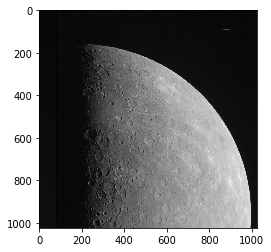

In [8]:
filename = "./DATA/" + date + "EW0220137668G.IMG"
name, image = get_image(filename)
plt.imshow(image, cmap = "gray")
plt.axis('off')
plt.show()

We then retrieve EN1049375684M.IMG. This only needs to be run once

In [9]:
url = "https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/2014_215/EN1049375684M.IMG"
r = requests.get(url)
#print(r.status_code)
if r.status_code != 404:
    with open("./DATA/EN1049375684M.IMG", 'wb') as fd:
        for chunk in r.iter_content(chunk_size=128):
            fd.write(chunk)
else:
    print("error 404")

And show the image

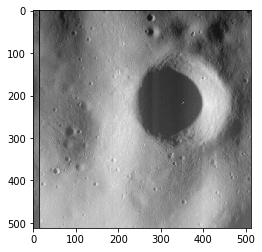

In [9]:
name, image = get_image("./DATA/EN1049375684M.IMG")
plt.imshow(image, cmap = "gray")
plt.axis('off')
plt.show()

## Task 2: Dataset preparation

The block below uses **discern**, extracts all the images from the specified date and puts them in an appropriate folder of *clean* or *CR*

0220157636_IM5WV doesn't have Cosmic Rays
0220157537_IM5WV doesn't have Cosmic Rays
0220157769_IM5WV doesn't have Cosmic Rays
0220156616_IM5WV doesn't have Cosmic Rays
0220157549_IM5WV doesn't have Cosmic Rays
0220143434_IM5WV doesn't have Cosmic Rays
0220157793_IM5WV has Cosmic Rays!
0220157546_IM5WV doesn't have Cosmic Rays
0220157677_IM5WV has Cosmic Rays!
0220159587_IM5WV doesn't have Cosmic Rays
0220159108_IM5WV doesn't have Cosmic Rays
0220159493_IM5WV doesn't have Cosmic Rays
0220155320_IM5WV doesn't have Cosmic Rays
0220155630_IM5WV doesn't have Cosmic Rays
0220143422_IM5WV has Cosmic Rays!
0220159991_IM5 doesn't have Cosmic Rays
0220159999_IM5 doesn't have Cosmic Rays
0220159190_IM5WV doesn't have Cosmic Rays
0220158385_IM5WV has Cosmic Rays!
0220159146_IM5WV doesn't have Cosmic Rays
0220157799_IM5WV has Cosmic Rays!
0220157590_IM5WV has Cosmic Rays!
0220157835_IM5WV doesn't have Cosmic Rays
0220157757_IM5WV doesn't have Cosmic Rays
0220156292_IM5WV doesn't have Cosmic Rays
02

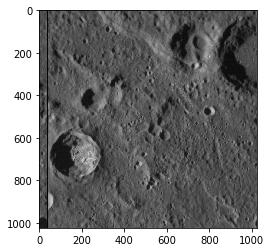

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev2 = "GPU" if torch.cuda.is_available() else "CPU"

for filename in glob.glob("./DATA/" + date + "*.IMG"):
    discern(filename,dev2)
    

We construct the dataset using the images from the given date. In a final product the dataset will be constructed from a list of dates, giving the user the ability to decide which images will be included.

In [11]:
root = "./DATA/" + date + "dataset"
trans = transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #For ResNet
    ])
data = datasets.ImageFolder(root=root, transform=trans)
train_set, test_set = split(data)
train_loader = DataLoader(data, batch_size=5, shuffle=True)
test_loader = DataLoader(data, batch_size=5, shuffle=True)

## Task 3: Machine Learning Algorithm

Because the dataset used for this test isn't huge, we tackle the problem of classification through [transfer learning](https://arxiv.org/pdf/1903.04687.pdf), specially, deep network adaptation. For that we use [resnet18](https://pytorch.org/hub/pytorch_vision_resnet/) as the pre-trained model and we just finetune the last, fully connected layer. In a final product, we can tackle with more scrutiny the transfer learning problem. 

In [12]:
#Taken from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters())

We train the model. At the end it shows the a plot of the loss with respect to epochs 

[1,    10] loss: 0.744
[1,    20] loss: 0.635
[2,    10] loss: 0.612
[2,    20] loss: 0.481
[3,    10] loss: 0.513
[3,    20] loss: 0.478
[4,    10] loss: 0.484
[4,    20] loss: 0.520
[5,    10] loss: 0.567
[5,    20] loss: 0.506
[6,    10] loss: 0.432
[6,    20] loss: 0.618
[7,    10] loss: 0.499
[7,    20] loss: 0.313
[8,    10] loss: 0.517
[8,    20] loss: 0.262
[9,    10] loss: 0.488
[9,    20] loss: 0.570
[10,    10] loss: 0.432
[10,    20] loss: 0.508
[11,    10] loss: 0.456
[11,    20] loss: 0.483
[12,    10] loss: 0.443
[12,    20] loss: 0.493
[13,    10] loss: 0.540
[13,    20] loss: 0.534
[14,    10] loss: 0.501
[14,    20] loss: 0.326
[15,    10] loss: 0.502
[15,    20] loss: 0.453
[16,    10] loss: 0.407
[16,    20] loss: 0.183
[17,    10] loss: 0.245
[17,    20] loss: 0.347
[18,    10] loss: 0.420
[18,    20] loss: 0.415
[19,    10] loss: 0.418
[19,    20] loss: 0.404
[20,    10] loss: 0.212
[20,    20] loss: 0.357
[21,    10] loss: 0.237
[21,    20] loss: 0.275
[22,    10

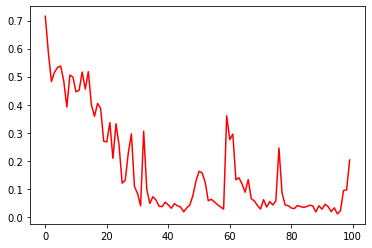

In [13]:
num_epochs = 100
model_ft = train(model_ft, train_loader, optimizer_ft, criterion, num_epochs, device)

We finally test the model and evaluate how does it fares according to the accuracy.

In [14]:
testing(model_ft, test_loader, device)

Accuracy of the network on the test set: 98 %


## Future work 

As mentioned above, the final code will:

1. Take command line arguments specifying the days and months that will be used.
2. If the flag for downloading is enabled, the scraper will download all the .IMG from the respective dates. This scraper can be customized to follow custom rules.
3. All the images from the .IMGs will be extracted and put in a corresponding folder by date, according to the presence of cosmic rays. This leaves the images neatly organized and archived.
4. A dataset will be constructed with the images taken from the dates the user specified (or a specific subset).
5. A network will be finetuned for the classification task with the dataset using transfer learning (maybe include the option of training a network from zero).
6. If the user wants, a selection of metrics will be displayed, alongside corresponding plots for the training and the testing phase.

In the end, the user only needs to specify the date from which the program will obtain and process the images. If a script is written, then it can be further automatized.


## Task 4: Showing Comsic rays artifacts

For this task we will show some Cosmic Rays artifacts from 5 images with known Cosmic Rays artifacts through cropping 

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev2 = "GPU" if torch.cuda.is_available() else "CPU"
mdl = deepCR(mask="ACS-WFC-F606W-2-32",inpaint="ACS-WFC-F606W-2-32",device=dev2)

**showCR** plots crops of the given image, centering around the cosmic rays artifacts 

In [9]:
def showCR(image,mask,sz):
    """Shows some cosmic rays artifacts from them given image
    Args:
        image (numpy array): image with cosmic rays artifacts
        mask (numpy array): binary mask showing the location of the cosmic rays
        sz(integer): size used for the crop, 
                            which will try to have a size of (crop_size*2,crop_size*2) 
    """
    crops = []
    crindex = np.where(mask==1) #Find the indexes of each CR artifact inside the image
    cr_row = crindex[0][0]
    cr_column = crindex[1][0]
    for i in range(len(crindex[0])):
        if i > 0:
            #If the next artifact is too close to the previous one, skip this iteration
            #As said artifact was shown in the last plot
            if (abs(crindex[0][i] - cr_row) < 100) and (abs(crindex[1][i] - cr_column) < 100): 
                continue
    
        yaxis = crindex[0][i]
        xaxis = crindex[1][i]
        top_margin = max(0,yaxis-sz)
        bottom_margin = min(image.shape[0]-1,yaxis+sz)
        left_margin = max(0,xaxis-sz)
        right_margin = min(image.shape[1]-1,xaxis+sz)

        crops.append(image[top_margin:bottom_margin,left_margin:right_margin])

        cr_row = crindex[0][i]
        cr_column = crindex[1][i]
      
    fig=plt.figure()  
    for j in range(1, len(crops)+1):
        fig.add_subplot(1, len(crops), j)
        plt.imshow(crops[j-1], cmap = "gray")
        plt.axis('off')
        
    plt.show()  

In [10]:
list_images = ["EW0220137668G.IMG","EW0215651174C.IMG","EW0215844301G.IMG",
               "EN0215728629M.IMG","EW0215726557D.IMG"]
list_dates = ["2011_207/", "2011_155/","2011_157/","2011_156/","2011_156/"]

We get 5 images that have known cosmic rays artifacts

In [11]:
url = "https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/"

for l in range(len(list_images)):
    r = requests.get(url + list_dates[l] + list_images[l])
    if r.status_code != 404:
        with open("DATA/"+ list_images[l], 'wb') as fd:
            for chunk in r.iter_content(chunk_size=128):
                fd.write(chunk)
    else:
        print("error 404")

the original image: EW0220137668G.IMG


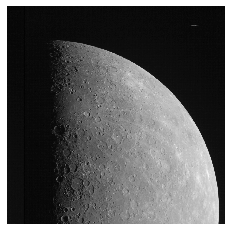

the CRs artifacts for EW0220137668G.IMG are: 


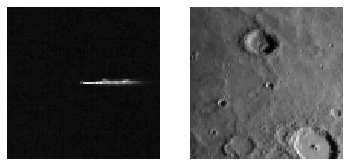

the original image: EW0215651174C.IMG


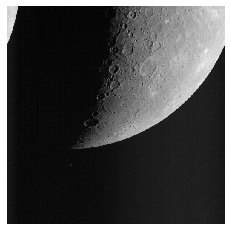

the CRs artifacts for EW0215651174C.IMG are: 


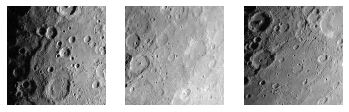

the original image: EW0215844301G.IMG


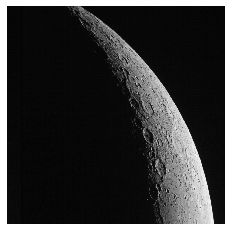

the CRs artifacts for EW0215844301G.IMG are: 


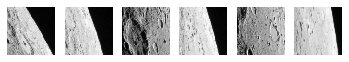

the original image: EN0215728629M.IMG


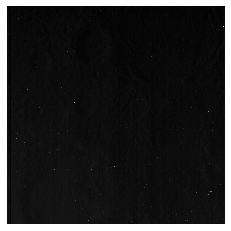

the CRs artifacts for EN0215728629M.IMG are: 


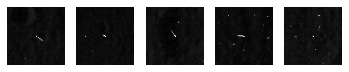

the original image: EW0215726557D.IMG


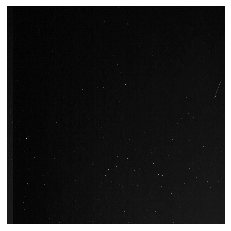

the CRs artifacts for EW0215726557D.IMG are: 


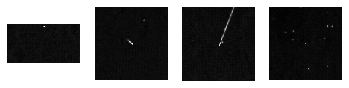

In [13]:
for k in range(5):
    name, image = get_image("DATA/" + list_images[k])
   
    print("the original image: " + list_images[k])
    plt.imshow(image, cmap = "gray")
    plt.axis('off')
    plt.show()
    
    print("the CRs artifacts for " + list_images[k] + " are: ")
    mask = mdl.clean(image, threshold = 0.5, inpaint=False) 
    showCR(image,mask,50)